In [33]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np

# Bonus vector manipulation
import pandas as pd
#from pandas import Dataframe
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import xarray as xr
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from pyproj import Proj, transform

import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')

client.get_versions(check=True)
client

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 15 Memory: 100.00 GB


In [3]:
import datacube
# DC utilities
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.import_export import export_xarray_to_netcdf
from datacube_utilities.createAOI import create_lat_lon
from datacube.storage import masking
from datacube_utilities.clean_mask import lee_filter

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [5]:
#aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
#testarea
#aoi_wkt = "POLYGON((177.75226467901712 -17.879622210337537,177.80204647833352 -17.879622210337537,177.80204647833352 -17.914988456071715,177.75226467901712 -17.914988456071715,177.75226467901712 -17.879622210337537))"
#aoi_wkt = "POLYGON((177.75226467901712 -17.879622210337537,177.80204647833352 -17.879622210337537,177.80204647833352 -17.914988456071715,177.75226467901712 -17.914988456071715,177.75226467901712 -17.879622210337537))"
#aoi_wkt = "POLYGON((177.34673877691375 -17.587272740290974,177.6955546948825 -17.587272740290974,177.6955546948825 -17.800529711996226,177.34673877691375 -17.800529711996226,177.34673877691375 -17.587272740290974))"
#FIJI area
#aoi_wkt = "POLYGON((177.34096527101 -17.746353149414, 177.43160247804 -17.744293212891, 177.4364089966 -17.834930419922, 177.34165191652 -17.833557128906, 177.34096527101 -17.746353149414))"
#Vanuatu area
aoi_wkt = "POLYGON((167.10255681550973 -15.387033221376983,167.37309514558785 -15.387033221376983,167.37309514558785 -15.63713057360639,167.10255681550973 -15.63713057360639,167.10255681550973 -15.387033221376983))"
#SI area
#aoi_wkt = "POLYGON((159.896905665708 -8.825812214638413,160.3638246110205 -8.825812214638413,160.3638246110205 -9.229982405677413,159.896905665708 -9.229982405677413,159.896905665708 -8.825812214638413))"
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')

In [46]:
#set baseline start and end of period
start_date = '2020-3-1'
end_date = '2020-9-30'
res = (20)
#Could make this Annual instead, '1Y'.
time_step = '1M'
platform = "SENTINEL_1"
#if Fiji
output_projection = "EPSG:3460"
# if SI or Vanuatu
crs = "EPSG:32760"
output_projection = "EPSG:32760"

In [11]:
dc = datacube.Datacube(app="s1_checks")

In [13]:
dask_chunks=dict(
    time = 1,
    x=1000,
    y=1000
)

In [14]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [15]:
display_map(latitude = lat_extents, longitude = lon_extents)

In [34]:
# crs's for input parameters 
inProj  = Proj("+init=EPSG:4326")
#this is hard coded can it be related to crs variable above. 
outProj = Proj("+init=EPSG:32760")

In [35]:
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)

In [36]:
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)

In [37]:
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)

In [38]:
#create resolution
resolution = (-res, res)

In [39]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(start_date, end_date)

In [40]:
allmeasurements = ["vv", "vh"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_1"]:
        product = 's1g_gamma0_scene'
        measurements = allmeasurements
    else:
        print("invalid platform")
    return product, measurements
product, measurement = create_product_measurement(platform)

### Load Data

Generic query specs

In [48]:
query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = output_projection,
                time = baseline_time_period,
                resolution = resolution,
                group_by = 'solar_day',
                dask_chunks = dask_chunks
            )



In [50]:
query = {
    'longitude': lon_range,
    'latitude': lat_range,
    'output_crs': output_projection,
    'resolution': resolution,
    'time': baseline_time_period,
    'crs': crs,
    'group_by': 'solar_day',
    'dask_chunks': dask_chunks,
}

In [53]:
ds = dc.load(
    platform = platform,
    product= product,
    measurements = measurement,
              **query)
ds

,Array,Chunk
Bytes,313.72 MB,4.00 MB
Shape,"(38, 1469, 1405)","(1, 1000, 1000)"
Count,204 Tasks,152 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,313.72 MB,4.00 MB
Shape,"(38, 1469, 1405)","(1, 1000, 1000)"
Count,204 Tasks,152 Chunks
Type,float32,numpy.ndarray


In [54]:

def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [56]:
print(ds.time)

<xarray.DataArray 'time' (time: 38)>
array(['2020-03-01T07:13:53.000000000', '2020-03-05T18:20:18.000000000',
       '2020-03-07T07:13:17.000000000', '2020-03-13T07:13:54.000000000',
       '2020-03-17T18:20:18.000000000', '2020-03-19T07:13:17.000000000',
       '2020-03-25T07:13:54.000000000', '2020-03-29T18:20:18.000000000',
       '2020-03-31T07:13:17.000000000', '2020-04-06T07:13:54.000000000',
       '2020-04-09T18:29:21.000000000', '2020-04-10T18:20:18.000000000',
       '2020-04-12T07:13:17.000000000', '2020-04-18T07:13:54.000000000',
       '2020-04-22T18:20:19.000000000', '2020-04-24T07:13:18.000000000',
       '2020-04-30T07:13:55.000000000', '2020-05-04T18:20:19.000000000',
       '2020-05-06T07:13:19.000000000', '2020-05-12T07:13:56.000000000',
       '2020-05-16T18:20:20.000000000', '2020-05-18T07:13:19.000000000',
       '2020-05-24T07:13:56.000000000', '2020-05-28T18:20:21.000000000',
       '2020-05-30T07:13:20.000000000', '2020-06-05T07:13:57.000000000',
       '2020-0

# TODO nodata masks

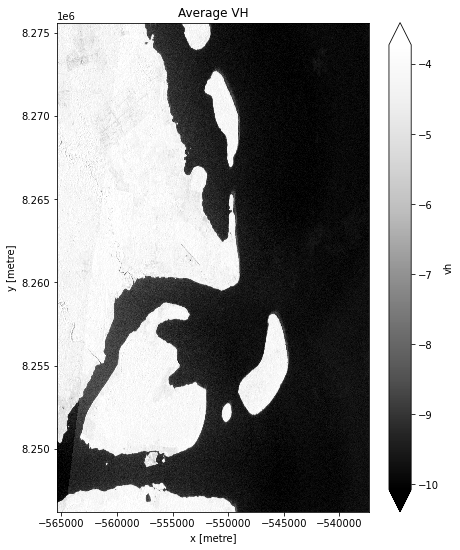

In [57]:
# Plot the average of all VH observations
mean_vh = ds.vh.mean(dim="time")

fig = plt.figure(figsize=(7, 9))
mean_vh.plot(cmap="Greys_r", robust=True)
plt.title("Average VH")
plt.show()

In [66]:
monthly_dual = ds.resample(time=time_step).mean(dim='time')

In [67]:
print(monthly_dual)

<xarray.Dataset>
Dimensions:      (time: 5, x: 1405, y: 1469)
Coordinates:
  * time         (time) datetime64[ns] 2020-03-31 2020-04-30 ... 2020-07-31
    spatial_ref  int32 32760
  * x            (x) float64 -5.654e+05 -5.654e+05 ... -5.373e+05 -5.373e+05
  * y            (y) float64 8.276e+06 8.276e+06 ... 8.246e+06 8.246e+06
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>


### Do we want extra bands

In [68]:
monthly_dual['vv-vh'] = monthly_dual['vh'] - monthly_dual['vv']

In [69]:
monthly_composite = monthly_dual.compute()

In [70]:
print(monthly_composite)

<xarray.Dataset>
Dimensions:      (time: 5, x: 1405, y: 1469)
Coordinates:
  * time         (time) datetime64[ns] 2020-03-31 2020-04-30 ... 2020-07-31
    spatial_ref  int32 32760
  * x            (x) float64 -5.654e+05 -5.654e+05 ... -5.373e+05 -5.373e+05
  * y            (y) float64 8.276e+06 8.276e+06 ... 8.246e+06 8.246e+06
Data variables:
    vv           (time, y, x) float32 -1.2891145 -1.5924615 ... -6.437513
    vh           (time, y, x) float32 -3.690974 -4.4530435 ... -10.555387
    vv-vh        (time, y, x) float32 -2.4018595 -2.8605819 ... -4.1178737


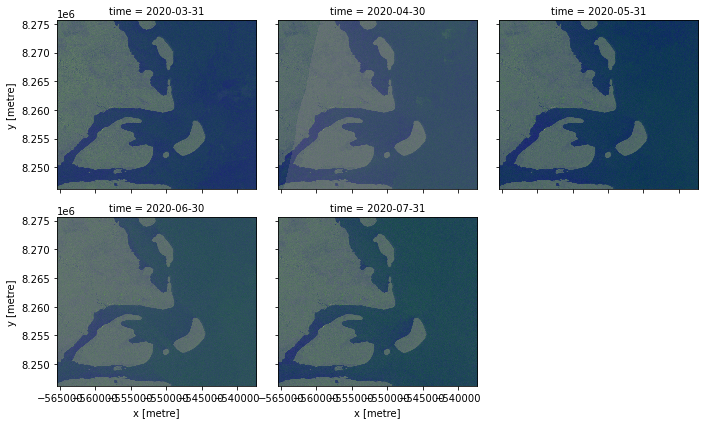

In [71]:
# Plot as three rgb
monthly_composite[['vh','vv','vv-vh']].to_array().plot.imshow(
    col='time',
    col_wrap=3,
    #figsize=(12, 8)
    #vmin=-10,
    #vmax=4
);

## TODO Export
